<a href="https://colab.research.google.com/github/naokishibuya/cuda-q-experiments/blob/main/notebooks/03_parameter_shift_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 — Parameter-Shift Gradients

## Why gradients matter in VQE

* VQE and similar algorithms minimize an expectation value $E(\boldsymbol\theta)=\langle \psi(\boldsymbol\theta)|H|\psi(\boldsymbol\theta)\rangle$.
* To optimize efficiently, we need $\nabla_{\boldsymbol\theta} E$.
* Gradient-free methods (Nelder-Mead, COBYLA) work but scale poorly and can be noisy.
* Gradient-based methods (BFGS, Adam, SGD) can converge faster if we can evaluate derivatives.

## The problem

We **can't backpropagate** through a quantum circuit easily, because it's not just a differentiable function in Python — it's a unitary acting on quantum states.

Naive finite differences:

$$
\partial_\theta E \approx \frac{E(\theta+h) - E(\theta)}{h}
$$

* Sensitive to choice of $h$.
* Requires many extra evaluations.
* High variance in hardware runs.

## The parameter-shift rule

For gates of the form

$$
U(\theta) = e^{-i \tfrac{\theta}{2} G}, \quad G^2 = I \quad (\text{Pauli generators}),
$$

we get an **exact identity**:

$$
\frac{\partial}{\partial \theta} E(\theta)
= \frac{1}{2}\Big[E(\theta+\tfrac{\pi}{2}) - E(\theta-\tfrac{\pi}{2})\Big].
$$

* Works for RY, RX, RZ, controlled versions, etc.
* Exact, not an approximation.
* Only doubles the number of circuit evaluations per parameter (two shifts).

It's important because:

* Makes **gradient-based optimizers practical** in VQE and QAOA.
* Robust to shot noise (you just need enough samples).
* Extends to **vector of parameters**: evaluate 2 circuits per parameter.

## Implementation

In the following cells,

1) Implement **parameter-shift gradients** for a small ansatz.
2) Compare **finite differences** vs **parameter shift**.
3) Try a **gradient-based optimizer** (BFGS) vs **gradient-free** (Nelder-Mead).
4) Plot convergence and verify we reach close to the ground energy of $H=Z_0Z_1 + X_0 + X_1$.


In [1]:
# Uncomment and install cuda-q if not already

# %pip install --upgrade pip
# %pip install cudaq

## Hamiltonian and Ansatz
We re-use the 4-parameter RY-CNOT-RY ansatz (real amplitudes) from the previous notebook, which can reach the exact ground energy for this 2-qubit Hamiltonian.


In [2]:
import cudaq
import numpy as np

# Hamiltonian: H = Z0 Z1 + X0 + X1
H = cudaq.spin.z(0) * cudaq.spin.z(1) + cudaq.spin.x(0) + cudaq.spin.x(1)
print('H =', str(H))

# Ansatz
def make_kernel():
    k, *params = cudaq.make_kernel(float, float, float, float)
    q = k.qalloc(2)

    k.ry(params[0], q[0])
    k.ry(params[1], q[1])
    k.cx(q[0], q[1])
    k.ry(params[2], q[0])
    k.ry(params[3], q[1])
    return k

# Expected energy: <H>
def energy(params: np.ndarray) -> float:
    k = make_kernel()
    obs = cudaq.observe(k, H, *params.tolist())
    return obs.expectation()

H = (1+0i) * Z0Z1 + (1+0i) * X0 + (1+0i) * X1


## Parameter-shift gradient
For gates of the form $U(\theta)=e^{-i\theta G/2}$ with eigenvalues $\pm 1$, the derivative obeys
$$\partial_\theta E(\theta) = \tfrac{1}{2}\big(E(\theta+\tfrac{\pi}{2}) - E(\theta-\tfrac{\pi}{2})\big).$$
RY rotations satisfy this. We implement a generic parameter-shift gradient for the energy.


In [3]:
from math import pi

# Parameter-Shift Gradients (Exact)
def grad_param_shift(params):
    params = np.array(params, dtype=float)
    g = np.zeros_like(params)
    for i in range(len(params)):
        # applying the parameter-shift for each parameter
        xp = params.copy(); xp[i] += pi/2
        xm = params.copy(); xm[i] -= pi/2
        g[i] = 0.5 * (energy(xp) - energy(xm))
    return g

# Finite-Difference Gradient (Approximation)
def grad_finite_diff(params, h=1e-4):
    params = np.array(params, dtype=float)
    g = np.zeros_like(params)
    base = energy(params)
    for i in range(len(params)):
        # applying the finite-difference for each parameter
        x = params.copy(); x[i] += h
        g[i] = (energy(x) - base) / h
    return g


# Quick check
x0 = np.array([0.3, -0.8, 0.5, -1.1])
gp = grad_param_shift(x0)
gf = grad_finite_diff(x0)
print('param-shift grad:', gp)
print('finite-diff  grad:', gf)

param-shift grad: [-0.8019929   0.69206998  0.85019665  0.54456368]
finite-diff  grad: [-0.80194373  0.69213814  0.8502023   0.54462886]


## Optimize: gradient-free vs gradient-based
We compare Nelder-Mead (no gradients) and BFGS (using parameter-shift gradients).

In [4]:
from scipy.optimize import minimize
import numpy as np

def energy_with_hist(x, hist):
    e = energy(x)
    hist.append(e)
    return e

x_init = np.array([0.2, 0.9, -0.4, 0.7])

# Histories
hist_nm, hist_bfgs = [], []

# Run optimizers
res_nm = minimize(
    energy,
    x0=x_init,
    callback=lambda x: energy_with_hist(x, hist_nm),
    method='Nelder-Mead',
    options={'maxiter':200, 'xatol':1e-6, 'fatol':1e-6})

res_bfgs = minimize(
    energy,
    x0=x_init,
    callback=lambda x: energy_with_hist(x, hist_bfgs),
    method='BFGS',
    jac=grad_param_shift, # Jacobian of single value cost func
    options={'maxiter':200, 'gtol':1e-6})

# Results
# x_star_nm, e_star_nm = res_nm.x, energy(res_nm.x)
# x_star_bg, e_star_bg = res_bfgs.x, energy(res_bfgs.x)
e_star_nm = energy(res_nm.x)
e_star_bg = energy(res_bfgs.x)

print('Nelder-Mead  -> E* =', e_star_nm)
print('BFGS (shift) -> E* =', e_star_bg)

Nelder-Mead  -> E* = -2.236067977499578
BFGS (shift) -> E* = -2.236067977499768


Both methods converge the same minimum energy.

## Plot convergence

Both methods can find the ground state, but gradient-based methods (BFGS + parameter-shift) converge faster and more efficiently than gradient-free methods like Nelder-Mead.

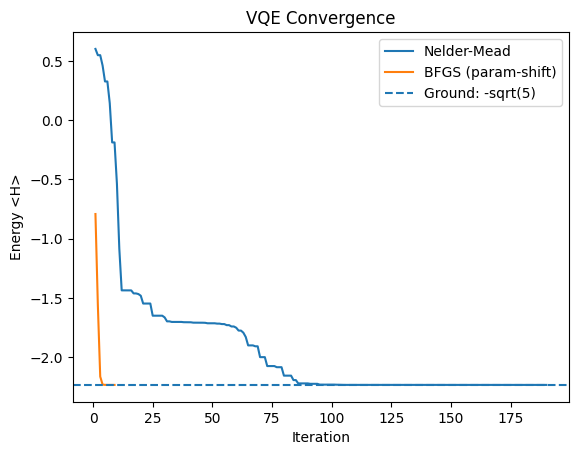

In [5]:
import matplotlib.pyplot as plt

plt.figure()
if hist_nm:
    plt.plot(np.arange(1, len(hist_nm)+1), np.array(hist_nm), label='Nelder-Mead')
if hist_bfgs:
    plt.plot(np.arange(1, len(hist_bfgs)+1), np.array(hist_bfgs), label='BFGS (param-shift)')
plt.axhline(-np.sqrt(5), linestyle='--', label='Ground: -sqrt(5)')
plt.xlabel('Iteration')
plt.ylabel('Energy <H>')
plt.title('VQE Convergence')
plt.legend()
plt.show()
